In [18]:
import pandas as pd
import numpy as np 
import torch 
import networkx as nx 
import omnipath as op 
from matplotlib import pyplot as plt 
import copy 
from pypath.utils import mapping

from gsnn.simulate.nx2pyg import nx2pyg

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from pypath.utils import mapping
from sklearn.metrics import r2_score

from scipy.stats import spearmanr

from gsnn_mds.data.AMLDataset import AMLDataset
from gsnn_mds.eval.stratified_drug_eval import stratified_drug_evaluation


In [19]:
aml_expr = pd.read_csv('../proc/aml_expr.csv')
data = torch.load('../proc/graph.pt', weights_only=False)
drug = pd.read_csv('../proc/resp.csv')

aml_expr = aml_expr.fillna(0)

id2x = {} 
expr_ixs = np.array([i for i,n in enumerate(data.node_names_dict['input']) if "EXPR__" in n])
expr_names = np.array(data.node_names_dict['input'])[expr_ixs]
for i,row in aml_expr.iterrows(): 
    x = torch.zeros(len(data.node_names_dict['input']), dtype=torch.float32)
    x[expr_ixs] = torch.tensor(row[expr_names].values.astype(np.float32), dtype=torch.float32)
    id2x[row.id] = x

In [20]:
drug_inputs = [x.split('__')[1] for x in data.node_names_dict['input'] if x.split('__')[0] == 'DRUG']

In [21]:
batch_size = 256

train_dataset = AMLDataset(id2x, drug[lambda x: x.partition == 'train'], data.node_names_dict['input'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)

test_dataset = AMLDataset(id2x, drug[lambda x: x.partition == 'test'], data.node_names_dict['input'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=10) 

val_dataset = AMLDataset(id2x, drug[lambda x: x.partition == 'val'], data.node_names_dict['input'])
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')
print(f'Number of train samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')
print(f'Number of val samples: {len(val_dataset)}')


Using device: cuda
Number of train samples: 30696
Number of test samples: 3503
Number of val samples: 5486


In [22]:
model = NN(in_channels=len(data.node_names_dict['input']), 
            hidden_channels=1024, 
            out_channels=1, 
            dropout=0.05, 
            layers=4, 
            norm=torch.nn.BatchNorm1d).to(device) 

print('# parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad) )

optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
crit = torch.nn.MSELoss() 


# parameters: 6354945


In [23]:
torch.cuda.empty_cache()

In [24]:
best_loss = float('inf')
best_state = None 

for epoch in range(100):
    model.train()
    train_loss = 0.
    train_r2 = 0.
    for i, (x,y) in enumerate(train_loader):
        optim.zero_grad()
        yhat = model(x.to(device))
        loss = crit(yhat.squeeze(), y.squeeze().to(device))
        loss.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2) 
        
        optim.step()
        train_loss += loss.item()
        r2 = r2_score(y.detach().numpy(), yhat.detach().cpu().numpy()) 
        train_r2 += r2
        print(f'[{i}/{len(train_loader)} Loss: {loss.item():.4f} || R2: {r2:.4f}]', end='\r')

    train_loss /= len(train_loader)
    train_r2 /= len(train_loader) 

    model.eval() 
    with torch.no_grad():
        ys = []
        yhats = []
        for x,y in val_loader:
            yhat = model(x.to(device))
            ys.append(y.squeeze().numpy())
            yhats.append(yhat.squeeze().detach().cpu().numpy())
        
        ys = np.concatenate(ys)
        yhats = np.concatenate(yhats)
        r2 = r2_score(ys, yhats)
        mse = np.mean((ys - yhats) ** 2) 
        sr = spearmanr(ys, yhats).correlation

    if mse < best_loss:
        best_loss = mse
        best_state = {k:v.clone().detach().cpu() for k,v in model.state_dict().items()}

    print(f'Epoch {epoch+1} || Train Loss: {train_loss:.4f} || Train R2: {train_r2:.4f} || Val MSE: {mse:.4f} || Val R2: {r2:.4f} || Val Spearman R: {sr:.4f}')

Epoch 1 || Train Loss: 0.6716 || Train R2: 0.1786 || Val MSE: 0.4782 || Val R2: 0.4280 || Val Spearman R: 0.6711
Epoch 2 || Train Loss: 0.4765 || Train R2: 0.4148 || Val MSE: 0.5137 || Val R2: 0.3855 || Val Spearman R: 0.6786
Epoch 3 || Train Loss: 0.4419 || Train R2: 0.4571 || Val MSE: 0.5135 || Val R2: 0.3858 || Val Spearman R: 0.6765
Epoch 4 || Train Loss: 0.4232 || Train R2: 0.4798 || Val MSE: 0.3920 || Val R2: 0.5311 || Val Spearman R: 0.7280
Epoch 5 || Train Loss: 0.4018 || Train R2: 0.5067 || Val MSE: 0.4076 || Val R2: 0.5124 || Val Spearman R: 0.7215
Epoch 6 || Train Loss: 0.3923 || Train R2: 0.5186 || Val MSE: 0.3915 || Val R2: 0.5317 || Val Spearman R: 0.7375
Epoch 7 || Train Loss: 0.3818 || Train R2: 0.5309 || Val MSE: 0.4046 || Val R2: 0.5161 || Val Spearman R: 0.7363
Epoch 8 || Train Loss: 0.3812 || Train R2: 0.5324 || Val MSE: 0.3827 || Val R2: 0.5422 || Val Spearman R: 0.7305
Epoch 9 || Train Loss: 0.3617 || Train R2: 0.5556 || Val MSE: 0.3801 || Val R2: 0.5453 || Val Sp

KeyboardInterrupt: 

In [25]:
model.load_state_dict(best_state) 
model = model.to(device)

xs = [] 
ys = [] 
yhats = [] 

model.eval()
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        yhat = model(x.to(device))
        xs.append(x.squeeze().detach().cpu().numpy())
        ys.append(y.squeeze().detach().numpy())
        yhats.append(yhat.squeeze().detach().cpu().numpy())  

xs = np.concatenate(xs, axis=0)
ys = np.concatenate(ys, axis=0)
yhats = np.concatenate(yhats, axis=0)


In [26]:
r2 = r2_score(ys, yhats)
r = np.corrcoef(ys, yhats)[0, 1] 
mse = np.mean((ys - yhats) ** 2)
sr = spearmanr(ys, yhats).correlation

print(f'R2: {r2:.4f}')
print(f'Pearson R: {r:.4f}')
print(f'MSE: {mse:.4f}')
print(f'Spearman R: {sr:.4f}')

R2: 0.4725
Pearson R: 0.6977
MSE: 0.4125
Spearman R: 0.6638


In [27]:
torch.save(model, '../proc/gsnn_aml.pt')

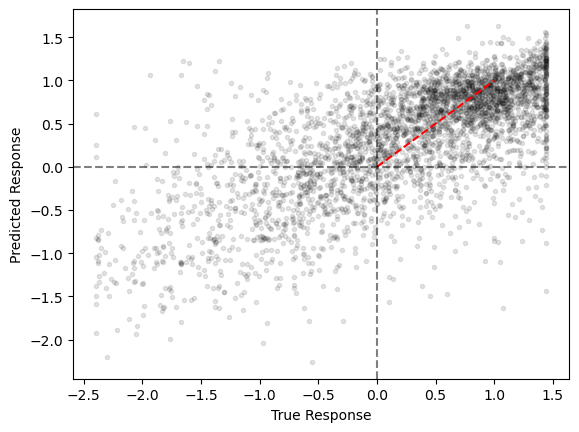

In [28]:
plt.figure() 
plt.plot(ys, yhats, 'k.', alpha=0.1)
plt.plot([0,1], [0,1], 'r--', alpha=1.)
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('True Response')
plt.ylabel('Predicted Response')
plt.show() 

In [29]:
res = stratified_drug_evaluation(xs, ys, yhats, data.node_names_dict)
res = pd.DataFrame(res)
res.head() 

,n_samples,r2,pearson_r,mse,spearman_r
drug_combination,,,,,
17-aag (tanespimycin),33,0.310937,0.597609,0.222521,0.483957
a-674563,33,-0.036891,0.253360,0.357563,0.232620
abt-737,18,-0.301009,-0.120862,0.403745,-0.145511
at7519,33,0.212247,0.464480,0.271344,0.326203
azd1480,33,0.015618,0.379293,0.277067,0.130024


In [30]:
res.sort_values(by='r2', ascending=False)
res.to_csv('drug_test_res_nn.csv', index=True)

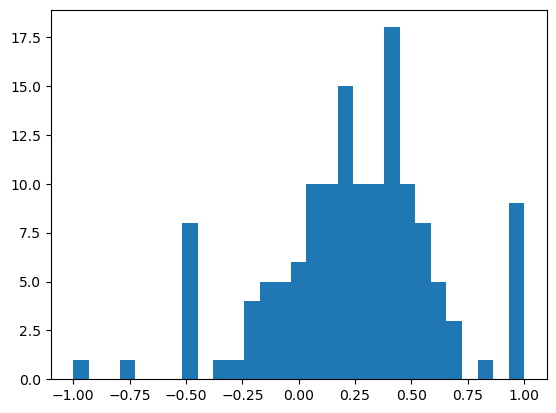

In [31]:
plt.figure() 
plt.hist(res.spearman_r, bins=np.linspace(-1, 1, 30))
plt.show()